In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import setGPU

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

setGPU: Setting GPU to: 1


In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [4]:
from gwpy.timeseries import TimeSeries

def filters(array, sample_frequency):
    strain = TimeSeries(array, sample_rate=int(sample_frequency))
    white_data = strain.whiten()
    bp_data = white_data.bandpass(30, 400)
    return(bp_data.value)


In [51]:
import h5py as h5

freq = 4
detector = 'L1'
train_start = 1185939456
num_train = 5
range_train = [0, 1, 2, 3, 4]
train_files = [train_start + i*4096 for i in range_train]
x = np.array([])

for file in train_files: 
    load = h5.File('/cvmfs/gwosc.osgstorage.org/gwdata/O2/strain.%sk/hdf.v1/%s/%s/%s-%s_GWOSC_O2_%sKHZ_R1-%s-4096.hdf5'%(str(freq),detector, str(train_start), detector[0], detector, str(freq), str(file)))
    x = np.concatenate((x, load['strain']['Strain'][()]), axis=0)

timesteps = 1000

x = filters(x, sample_frequency=4000)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(x.reshape(-1, 1)).reshape(-1)
if X_train.shape[0]%timesteps != 0: 
        X_train = X_train[:-1*int(X_train.shape[0]%timesteps)]

In [52]:
class AudioFile(torch.utils.data.Dataset):
    def __init__(self, timeseries):
        self.data = timeseries
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        scale = np.max(np.abs(amplitude))
        amplitude = (amplitude / scale)
        amplitude = torch.Tensor(amplitude).view(-1, 1)
        return self.timepoints, amplitude

In [53]:
batch_audio = AudioFile(X_train)
dataloader = DataLoader(batch_audio, shuffle=True, batch_size=1, pin_memory=False, num_workers=2)

# Note that we increase the frequency of the first layer to match the higher frequencies of the
# audio signal. Equivalently, we could also increase the range of the input coordinates.
audio_siren = Siren(in_features=1, out_features=1, hidden_features=128, 
                    hidden_layers=2, first_omega_0=1500, outermost_linear=True)
audio_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=1, out_features=128, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

Step 0, Total loss 0.000012


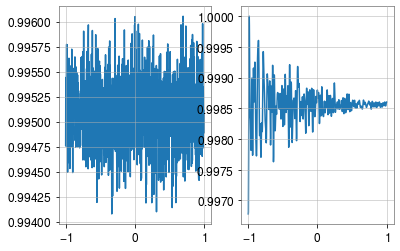

Step 5, Total loss 0.000015


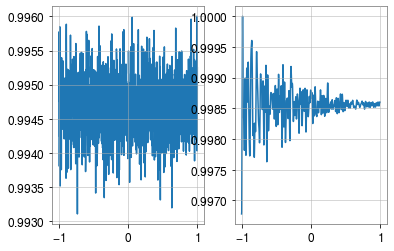

Step 10, Total loss 0.000017


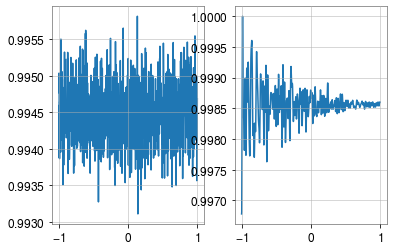

Step 15, Total loss 0.000017


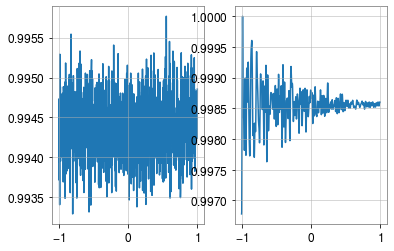

Step 20, Total loss 0.000019


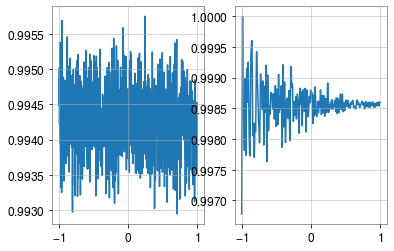

Step 25, Total loss 0.000019


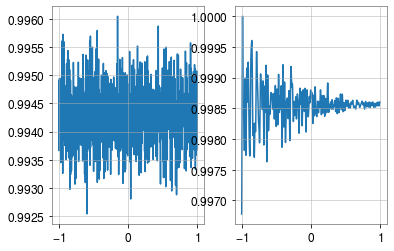

Step 30, Total loss 0.000019


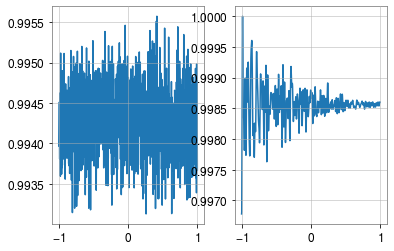

Step 35, Total loss 0.000019


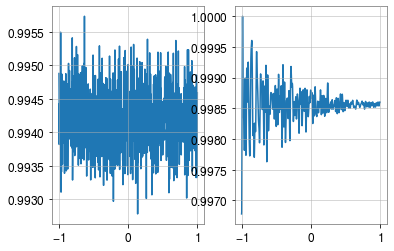

Step 40, Total loss 0.000019


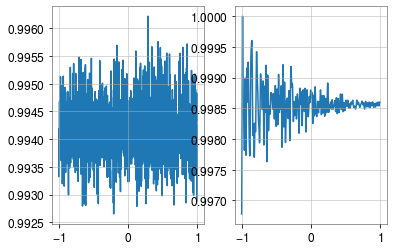

Step 45, Total loss 0.000018


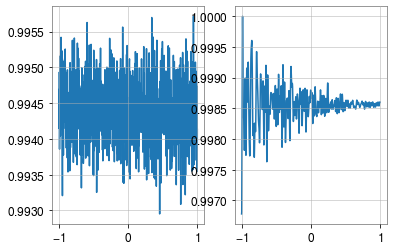

Step 50, Total loss 0.000017


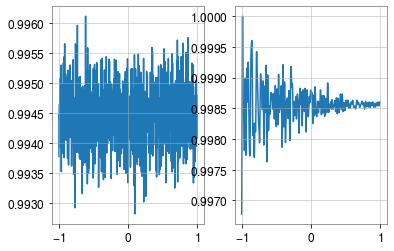

Step 55, Total loss 0.000016


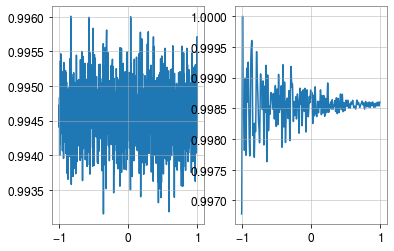

Step 60, Total loss 0.000017


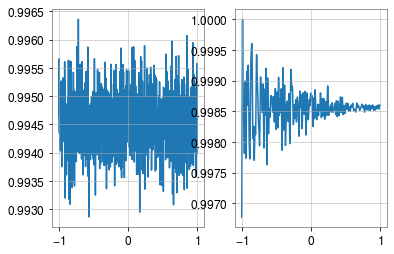

Step 65, Total loss 0.000017


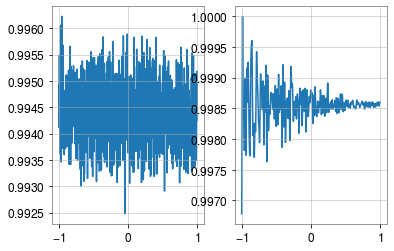

Step 70, Total loss 0.000017


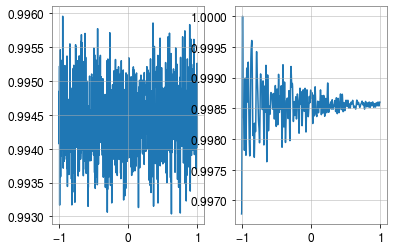

Step 75, Total loss 0.000019


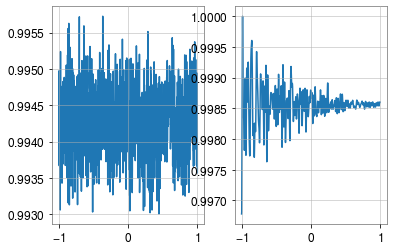

Step 80, Total loss 0.000020


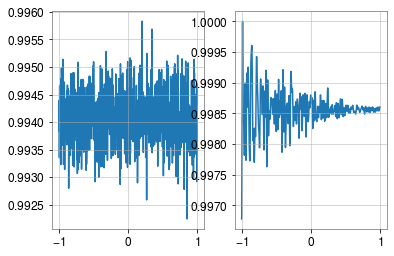

KeyboardInterrupt: 

In [70]:
total_steps = 200
steps_til_summary = 5

optim = torch.optim.Adam(lr=1e-4, params=audio_siren.parameters())

data = iter(dataloader)
#model_input, ground_truth = next(data)
#model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    
    for subdata in range(int(len(X_train)/timesteps)):
        
        
        
        x = X_train[subdata*timesteps:(subdata+1)*timesteps]   
        #model_input, ground_truth = next(data)
        model_input, ground_truth = next(iter(DataLoader(AudioFile(x), shuffle=True, batch_size=1, pin_memory=False, num_workers=0)))
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
        #print(model_input)
        #print(ground_truth)
        #model_input_temp = model_input[:][subdata*100:(subdata+1)*100][:]
        #ground_truth_temp = ground_truth[:][subdata*100:(subdata+1)*100][:]
        #print(model_input_temp.shape)
        #print(ground_truth_temp.shape)
        model_output, coords = audio_siren(model_input)    
        loss = F.mse_loss(model_output, ground_truth)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,2)
        axes[0].plot(coords.squeeze().detach().cpu().numpy(),model_output.squeeze().detach().cpu().numpy())
        axes[1].plot(coords.squeeze().detach().cpu().numpy(),ground_truth.squeeze().detach().cpu().numpy())
        plt.show()

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170104/v2/L-L1_GWOSC_4KHZ_R1-1167557889-4096.hdf5
(1, 245000, 1)
(245, 1000, 1)
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170608/v3/L-L1_GWOSC_4KHZ_R1-1180920447-4096.hdf5
(1, 245000, 1)
(245, 1000, 1)
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170729/v1/L-L1_GWOSC_4KHZ_R1-1185387760-4096.hdf5
(1, 245000, 1)
(245, 1000, 1)
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170809/v1/L-L1_GWOSC_4KHZ_R1-1186300472-4096.hdf5
(1, 245000, 1)
(245, 1000, 1)
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170814/v3/L-L1_GWOSC_4KHZ_R1-1186739814-4096.hdf5
(1, 245000, 1)
(245, 1000, 1)
Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW170817/v3/L-L1_GWOSC_4KHZ_R1-1187006835-4096.hdf5
(1, 245000, 1)
(245, 1000, 1)
Downloading:  https://www.gw-openscience.org/eventap

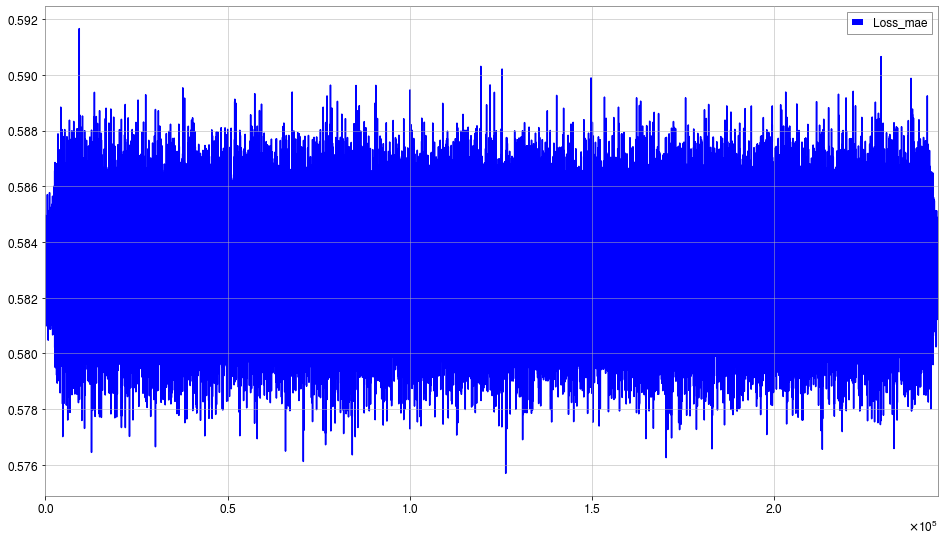

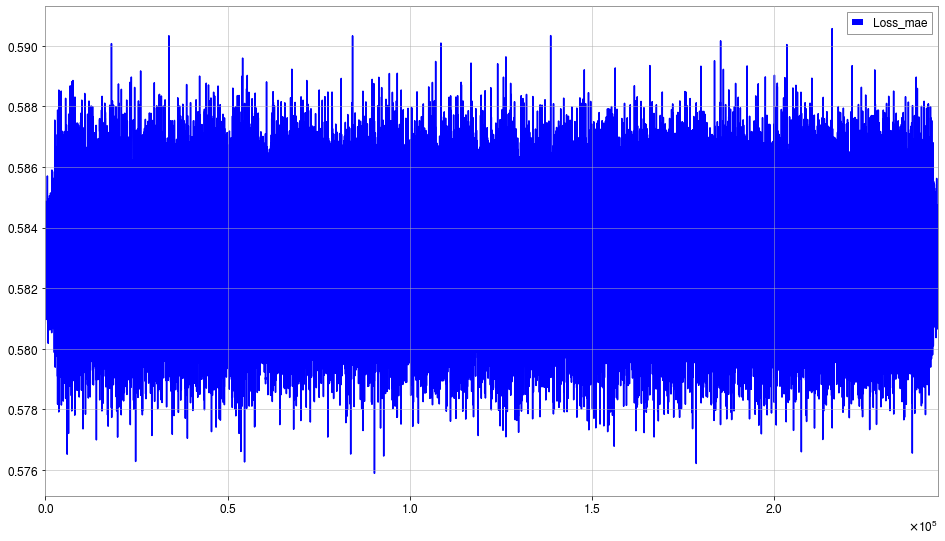

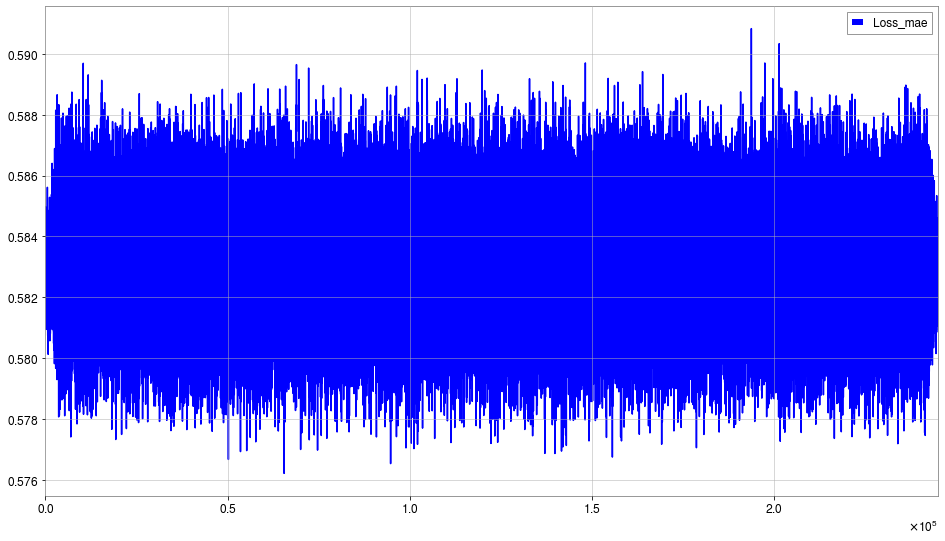

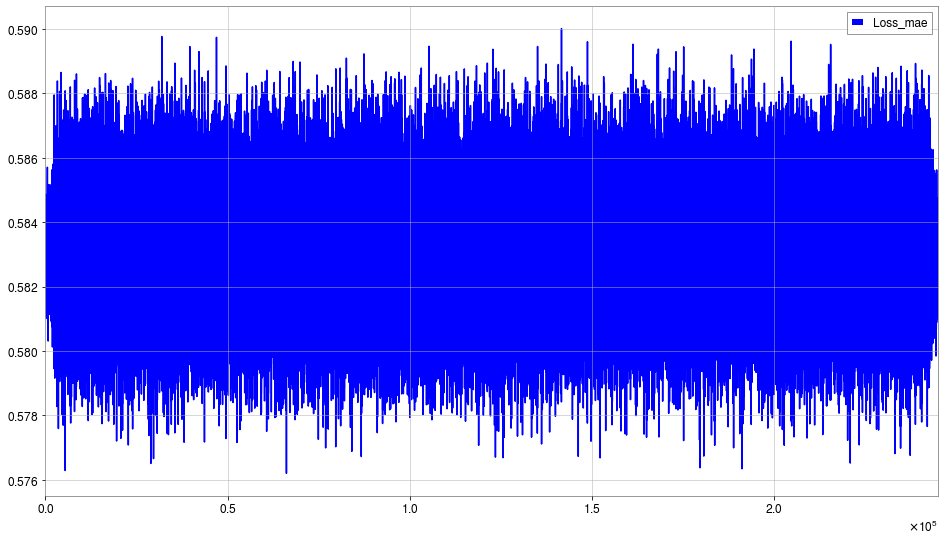

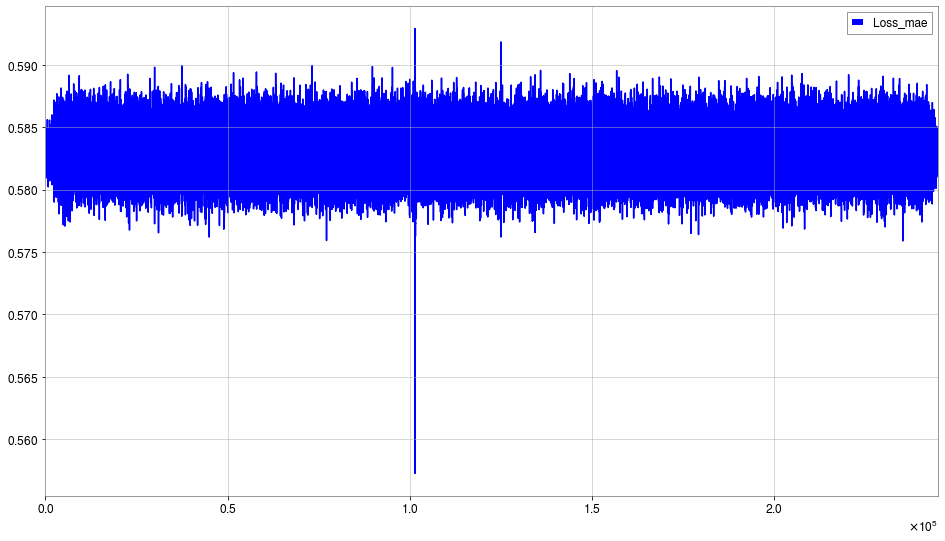

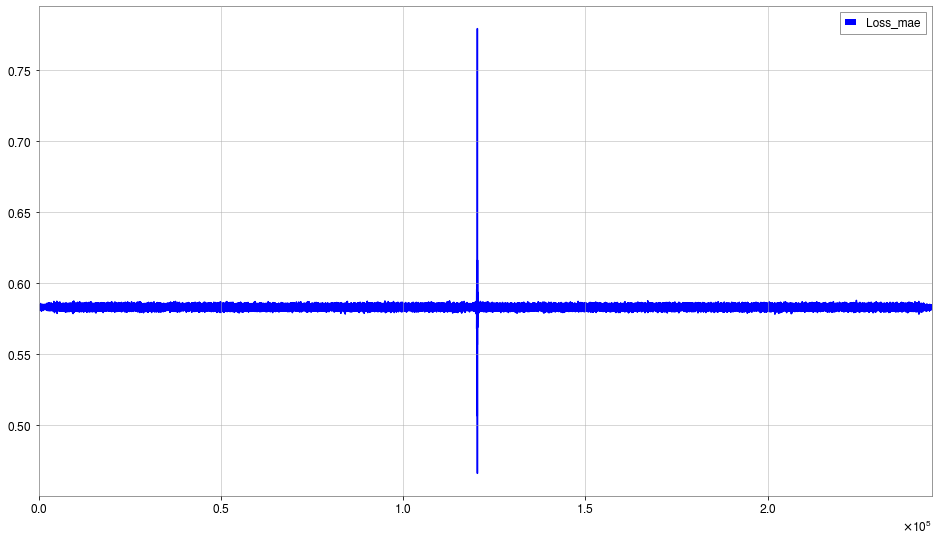

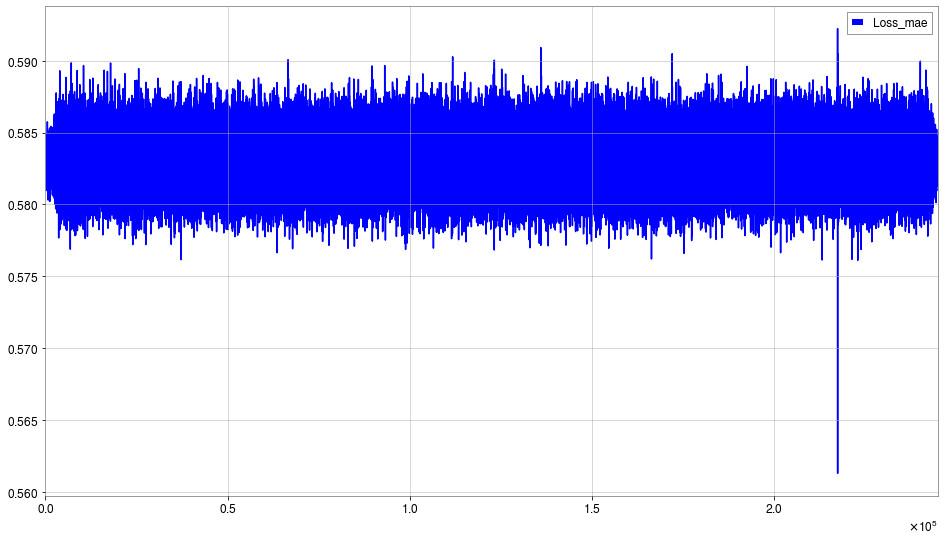

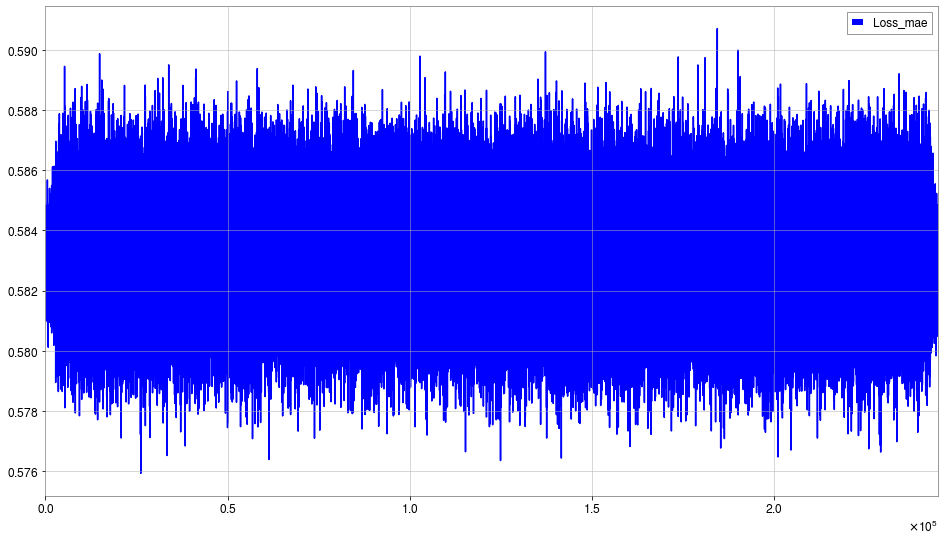

In [71]:
GW_GPS_confirmed = [1167559936.6, 1180922494.5, 1185389807.3, 1186302519.8, 1186741861.5, 1187008882.4, 1187058327.1, 1187529256.5]
import requests
import pandas as pd

for t0 in GW_GPS_confirmed: 
    from gwosc.locate import get_urls
    try:
        url = get_urls(detector, t0, t0)[-1]
    except: 
        continue 
    print('Downloading: ' , url)
    fn = os.path.basename(url)
    with open(fn,'wb') as strainfile:                 
        straindata = requests.get(url)
        strainfile.write(straindata.content)

    strain = TimeSeries.read(fn,format='hdf5.losc')
    center = int(t0)
    strain = strain.crop(center-30, center+30)

    white_data = strain.whiten()
    bp_data = white_data.bandpass(30, 400)
    X_test = scaler.transform(bp_data.value.reshape(-1, 1))

    if X_test.shape[0]%timesteps != 0: 
        X_test = X_test[:-1*int(X_test.shape[0]%timesteps)]
    
    #X_test = X_test.reshape(int(X_test.shape[0]/timesteps), timesteps, X_test.shape[1])
    batch_audio = AudioFile(X_test)
    dataloader = DataLoader(batch_audio, shuffle=True, batch_size=1, pin_memory=False, num_workers=2)
    data = iter(dataloader)
    model_input, ground_truth = next(iter(DataLoader(AudioFile(X_test), shuffle=True, batch_size=1, pin_memory=False, num_workers=0)))
    '''
    for subdata in range(int(len(X_test)/timesteps)):     
        x = X_test[subdata*timesteps:(subdata+1)*timesteps]   
        model_input, ground_truth = next(iter(DataLoader(AudioFile(x), shuffle=True, batch_size=1, pin_memory=False, num_workers=0)))
        model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
        model_output, coords = audio_siren(model_input)    

    model_input, ground_truth = next(iter(dataloader))
    '''
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    
    X_pred_test = audio_siren(model_input)[0].detach().cpu().numpy()
    print(X_pred_test.shape)
    X_pred_test = X_pred_test.reshape(-1, timesteps, 1)
    print(X_pred_test.shape)
    X_pred_test = X_pred_test.reshape(X_pred_test.shape[0]*timesteps, X_pred_test.shape[2])
    X_pred_test = pd.DataFrame(X_pred_test)
    #X_pred_train.index = train.index
    X_test = X_test.reshape(-1, timesteps, 1)
    Xtest = X_test.reshape(X_test.shape[0]*timesteps, X_test.shape[2])

    scored_test = pd.DataFrame()
    scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
    #scored_test['Threshold'] = threshold
    #scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']
    #scored_test.plot(logy=True,  figsize=(16,9), ylim=[t/(1e2),threshold*(1e2)], color=['blue','red'])
    scored_test.plot(logy=False,  figsize=(16,9), color=['blue','red'])
    outdir = 'test'
    plt.savefig('%s/test_threshold_%s_pm30sec.jpg'%(outdir, t0))

In [14]:
print(model_input.shape)

torch.Size([4, 1000, 1])
